In [6]:
import pandas as pd
import numpy as np

In [7]:
df= pd.read_csv("Twitter_Data.csv")

In [8]:
print(df.head())

                                          clean_text  category
0  when modi promised “minimum government maximum...      -1.0
1  talk all the nonsense and continue all the dra...       0.0
2  what did just say vote for modi  welcome bjp t...       1.0
3  asking his supporters prefix chowkidar their n...       1.0
4  answer who among these the most powerful world...       1.0


In [9]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162980 entries, 0 to 162979
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   clean_text  162976 non-null  object 
 1   category    162973 non-null  float64
dtypes: float64(1), object(1)
memory usage: 2.5+ MB
None


In [10]:
print(df["category"].value_counts())

category
 1.0    72250
 0.0    55213
-1.0    35510
Name: count, dtype: int64


In [11]:
df['label']=df['category'].apply(lambda x:2 if x==-1.0 else (1 if x==1.0 else 0))

In [12]:
df.head()

,clean_text,category,label
0,when modi promised “minimum government maximum...,-1.0,2
1,talk all the nonsense and continue all the dra...,0.0,0
2,what did just say vote for modi welcome bjp t...,1.0,1
3,asking his supporters prefix chowkidar their n...,1.0,1
4,answer who among these the most powerful world...,1.0,1


In [13]:
df = df.drop(columns=['category'])

In [14]:
df.head()

,clean_text,label
0,when modi promised “minimum government maximum...,2
1,talk all the nonsense and continue all the dra...,0
2,what did just say vote for modi welcome bjp t...,1
3,asking his supporters prefix chowkidar their n...,1
4,answer who among these the most powerful world...,1


In [15]:
df.isnull().sum()

clean_text    4
label         0
dtype: int64

In [16]:
df.dropna(axis=0, inplace=True)

In [17]:
df.isnull().sum()

clean_text    0
label         0
dtype: int64

In [18]:
df.shape

(162976, 2)

In [19]:
data= df[:15000]

In [20]:
print(data['label'].value_counts())

label
1    6217
0    5201
2    3582
Name: count, dtype: int64


<Axes: xlabel='label'>

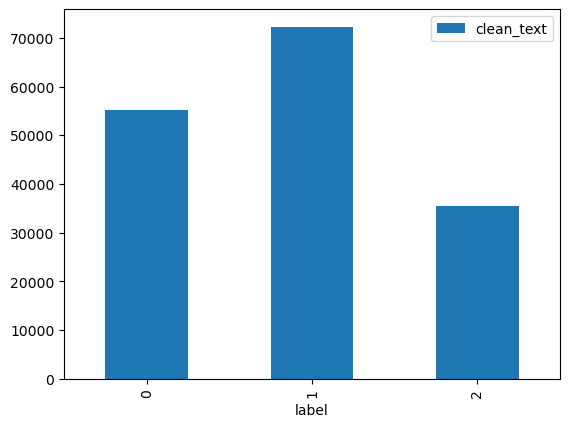

In [21]:
df.groupby('label').count().plot(kind='bar')

<Axes: >

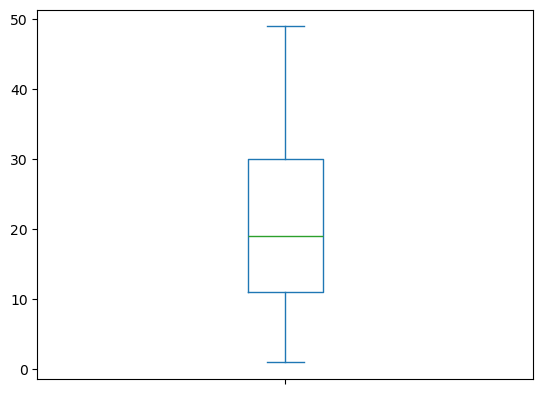

In [22]:
tweet=pd.Series([len(tweet.split()) for tweet in data["clean_text"]])
tweet.plot(kind="box")

In [23]:
import nltk
nltk.download("wordnet")

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\anith\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [24]:
import re


In [25]:
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

In [26]:
def preprocess_text(text):
    text=text.lower()
    text= re.sub(r'[^a-zA-Z\s]', '', text)
    tokens=word_tokenize(text)
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in tokens]
    stop_words=set(stopwords.words('english'))
    filtered_tokens=[word for word in lemmatized_tokens if word not in stop_words]
    processed_text=''.join( filtered_tokens)
    return processed_text
data['text'] = data['clean_text'].apply(preprocess_text)

C:\Users\anith\AppData\Local\Temp\ipykernel_10348\3296909781.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['text'] = data['clean_text'].apply(preprocess_text)


In [27]:
from keras.preprocessing.text import Tokenizer

In [28]:
tweets=data["text"].values
labels=data["label"].values

In [29]:
tokenizer=Tokenizer()
tokenizer.fit_on_texts(tweets)

In [30]:
sequences = tokenizer.texts_to_sequences(tweets)

In [31]:
word_index=tokenizer.word_index

In [32]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from nltk.tokenize import word_tokenize

In [33]:
from sklearn.feature_extraction.text import CountVectorizer

In [34]:
vectorizer=CountVectorizer(ngram_range=(1,3))
X_nagrams= vectorizer.fit_transform(tweets)

In [35]:
from keras_preprocessing.sequence import pad_sequences

In [36]:
max_sequence_length = max([len(seq) for seq in sequences])
X_padded = pad_sequences(sequences, maxlen=max_sequence_length)

In [39]:
num_classes=len(set(labels))
y= np.zeros((len(labels),num_classes))

In [40]:
for i, label in enumerate(labels):
    y[i, label]=1

In [42]:
x_train, x_test, y_train, y_test=train_test_split(X_padded,y, test_size=0.2,random_state=42)

In [46]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout


In [49]:
embedding_size = 100
lstm_size = 128
model = Sequential()
model.add(Embedding(len(word_index)+1, embedding_size, input_length=max_sequence_length))
model.add((LSTM(lstm_size, dropout=0.2, recurrent_dropout=0.2)))
model.add(Dense(num_classes, activation='softmax'))


In [52]:
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['accuracy'])

In [53]:

history=model.fit(x_train,y_train, batch_size=128, epochs=5, validation_data=(x_test,y_test))

Epoch 1/5
94/94 [==============================] - 11s 51ms/step - loss: 1.0811 - accuracy: 0.4105 - val_loss: 1.0750 - val_accuracy: 0.4207
Epoch 2/5
94/94 [==============================] - 3s 35ms/step - loss: 0.9402 - accuracy: 0.5586 - val_loss: 1.0710 - val_accuracy: 0.4150
Epoch 3/5
94/94 [==============================] - 4s 38ms/step - loss: 0.1388 - accuracy: 0.9984 - val_loss: 1.2006 - val_accuracy: 0.3737
Epoch 4/5
94/94 [==============================] - 5s 51ms/step - loss: 0.0035 - accuracy: 0.9996 - val_loss: 1.2296 - val_accuracy: 0.3663
Epoch 5/5
94/94 [==============================] - 4s 40ms/step - loss: 0.0020 - accuracy: 0.9998 - val_loss: 1.2420 - val_accuracy: 0.3643


In [54]:
model.save('model1.h5')

In [57]:
y_pred=model.predict(x_test)
y_pred=np.argmax(y_pred, axis=1)
y_true=np.argmax(y_test, axis=1)

94/94 [==============================] - 1s 5ms/step


In [58]:
accuracy=accuracy_score(y_true,y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.36433333333333334


In [59]:
import matplotlib.pyplot as plt

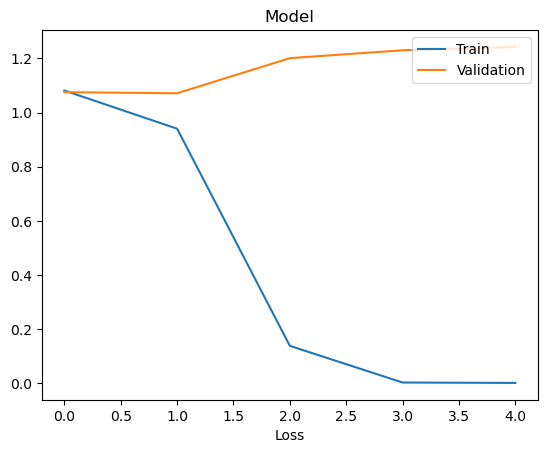

In [62]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model')
plt.xlabel('Epoch')
plt.xlabel('Loss')
plt.legend(['Train','Validation'], loc='upper right')
plt.show()

